# Algoithmic Fairness, Accountability and Ethics
## Assignment 2 (Template)

In [77]:
from folktables import ACSDataSource, BasicProblem, generate_categories
import numpy as np
import scipy.optimize as opt

### 1. Load and Preprocess the data
We are going to work with the [Folktables](https://github.com/socialfoundations/folktables#quick-start-examples) dataset (*you have already worked with it*).

1. As last week, we are still predicting the *Total person's income*  (I've digitized  it in  `target_transform=lambda x: x > 25000`).
2. Today, we are going to implement two methods for data debiasing: [Fair PCA](https://deepai.org/publication/efficient-fair-pca-for-fair-representation-learning) and [A Geometric Solution to Fair Representations](https://dl.acm.org/doi/10.1145/3375627.3375864).
3. We are going to evaluate the performance on two sensitive features: `SEX` (i.e. *Males* and *Females*) and `RAC1P` (we will consider only *Whites* and *African-Americans*)
4. I updated the filtering method `adult_filter` to keep the specified groups.

In [78]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

def adult_filter(data):
    """Mimic the filters in place for Adult data.
    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df = df[df["RAC1P"] < 3] ## keep only Whites and African-Americans
    return df


ACSIncomeNew = BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'CIT',
        'RELP',
        'WKHP',
        'PWGTP',
        'SEX',
        'RAC1P'
    ],
    target='PINCP',
    target_transform=lambda x: x > 25000,    
    group=['SEX', "RAC1P"],
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

## Task 1

In [79]:
######
## YOUR CODE
#####

## Task 2

### Convert categorical to one-hot encoding

In [80]:
definition_df = data_source.get_definitions(download=True)
_categories = generate_categories(features=ACSIncomeNew.features, definition_df=definition_df)
_all_features, _labels, _groups = ACSIncomeNew.df_to_pandas(acs_data, categories=_categories, dummies=True)
### groups now contain information about SEX and RAC1P

In [81]:
# Drop the "redundant" columns
_features = _all_features.drop(["RELP_Unmarried partner",
                          "CIT_U.S. citizen by naturalization",
                          "SEX_Male",
                          "SCHL_1 or more years of college credit, no degree",  
                          "MAR_Divorced", 
                          "RELP_Adopted son or daughter",
                          'COW_Working without pay in family business or farm', 
                          "RAC1P_White alone" ], axis = 1) 

print("Columns with the protected features:")
for i, f in enumerate(_features.columns):
    if ("RAC1P" in f) or ("SEX" in f):
        print("Column ID: %s" %i, "(%s)"%f)

Columns with the protected features:
Column ID: 57 (SEX_Female)
Column ID: 58 (RAC1P_Black or African American alone)


In [82]:
from sklearn.model_selection import train_test_split

In [174]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    _features, _labels, _groups, test_size=0.3, random_state=0, shuffle=True)

N = 500 ### I am subsampling because it is slow on my machine

X_train = X_train[:N]
y_train = y_train[:N]
group_train = group_train[:N]
X_test = X_test[:N]
y_test = y_test[:N]
group_test = group_test[:N]

full_train = pd.concat([X_train, group_train], axis=1)
full_test = pd.concat([X_test, group_test], axis=1)

X_cols = X_train.columns.to_list()
group_cols = group_train.columns.to_list()
feature_cols = X_cols[:-2]

not_x_cols = ['RAC1P_Black or African American alone', 'SEX_Female'] + group_cols

### Build your own implementation of the Logistic Regression with L2-penalty (aka Ridge Regression).

In [213]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import sklearn
import pandas as pd

def sigmoid(x, eps=1e-10):
    """
    This is logistic regression
    f = 1/(1+exp(-beta^T * x))
    This function assumes as input that you have already multiplied beta and X together
    """
    return 1 / (1 + np.exp(-x+eps))


def logistic_loss(y_true, y_pred, eps=1e-10):
    """
    Loss for the logistic regression, y_preds are probabilities
    eps: epsilon for stability
    """
    return np.mean(
        -y_true * np.log(y_pred+eps) - (1 - y_true) * np.log(1 - y_pred+eps)
    )


def l2_loss(beta):
    """
    L2-Regularisation
    """
    return np.sum(beta[1:]**2)


def individual_fairness_loss(y, y_pred, all_groups):
    """
    individual fairness Loss
    """
    fairness = 0
    for groups in all_groups.T:

        y, y_pred, groups = [
            pd.Series(np.squeeze(data), name=name)
            for name, data in [("y", y), ("y_pred", y_pred), ("groups", groups)]
        ]
        X_groups = pd.concat([y, y_pred], axis=1).groupby(groups)
        X_g1, X_g2 = X_groups.get_group(1), X_groups.get_group(2)

        cross_pairs = X_g1.merge(X_g2, how="cross", suffixes=["1", "2"])
        assert len(cross_pairs) == len(X_g1) * len(X_g2)

        df = cross_pairs
        fairness += np.mean((df["y1"] == df["y2"]) * (df["y_pred1"] - df["y_pred2"])**2)
    return fairness


def compute_gradient(beta, X, y, groups, _lambda, _gamma):
    """Calculate the gradient - used for finding the best beta values.
    You do not need to use groups and lambda (fmin_tnc expects same input as in func, that's why they are included here)"""
    y_pred = predict(X, beta)

    grad = 1/len(y) * ((y_pred - y) @ X)
    grad[1:] += 2 * _gamma * beta[1:]
    assert grad.shape == beta.shape, "gradient shape doesnt match beta shape"
    return grad


def compute_cost(beta, X, y, groups, _lambda, _gamma):
    """Computes cost function with constraints"""
    y_pred = predict(X, beta)

    loss = logistic_loss(y, y_pred) + _gamma*l2_loss(beta)# + _lambda*individual_fairness_loss(y, y_pred, groups)
    return loss


def predict(X, beta):
    return sigmoid(X @ beta)

class LogReg(BaseEstimator):
    def __init__(self, gamma, lambda_):
        self.gamma = gamma
        self.lambda_ = lambda_
        self.scaler = StandardScaler().set_output(transform='pandas')

    def _add_bias(self, X_train):
        bias = pd.Series(np.ones_like(X_train.shape[1]), name="bias", index=X_train.index, dtype=float)
        return pd.concat([bias, X_train], axis=1)
    
    def fit(self, X_train, y_train):
        groups = X_train[group_cols].values
        X_train = X_train[[c for c in X_train if c not in group_cols]]

        X_train = self.scaler.fit_transform(X_train)
        X_train = self._add_bias(X_train)

        X = X_train.values
        y = y_train.astype(float).squeeze().values
        train_func = lambda: opt.fmin_tnc(
            func=compute_cost,
            x0=self.init_beta,
            fprime=compute_gradient,
            #approx_grad=True,
            maxfun=500,
            args=(X, y, groups, self.lambda_, self.gamma),
            ftol=1e-5,
        )

        TRIES = 1
        for i in range(TRIES):
            self.init_beta = np.random.rand(len(X_train.T))

            self.beta, _, state = train_func()

            if state in [0, 1, 2]:
                break

            else:
                self.beta = np.array([np.nan]*len(self.beta))
                print(f'failed {state = }')

    
    def predict(self, X_train):
        X_train = X_train[[c for c in X_train if c not in group_cols]]
        X_train = self.scaler.transform(X_train)
        X_train = self._add_bias(X_train)
        return predict(X_train.values, self.beta).round()
    
    def score(self, X_train, y_train):
        groups = X_train[group_cols].values
        X_train = X_train[[c for c in X_train if c not in group_cols]]

        X_train = self.scaler.transform(X_train)
        X_train = self._add_bias(X_train)
        X = X_train.values
        y = y_train.astype(float).squeeze().values
        return -compute_cost(self.beta, X, y, groups, self.lambda_, self.gamma)

# Check all functions work
clf = LogReg(gamma=1e-5, lambda_=1e3)
clf.fit(full_train, y_train)
(clf.predict(full_train) == y_train.squeeze()).mean()

C:\Users\Christoffer\AppData\Local\Temp\ipykernel_4856\2144951800.py:18: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x+eps))


0.836

### Use Cross-Validation to find the most optimal value for L2-penalty (you should implement it yourself).


#### Task 2.2.
Use the following arguments in the `opt.fmin_funct`: `xtol=1e-4, ftol=1e-4,  maxfun=1000`

In [114]:
gammas = [10**i for i in (-5, -4, -3, -2, -1)]
lambdas = [1e4] #[10**i for i in range(1, 5+1)]
cv = GridSearchCV(
    estimator=clf,
    param_grid={"gamma": gammas, "lambda_": lambdas},
    verbose=2,
    n_jobs=-1
)
cv.fit(full_train, y_train.squeeze())
cv.cv_results_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'mean_fit_time': array([0.31663117, 0.28282008, 0.12000942, 0.07836952, 0.04096994]),
 'std_fit_time': array([0.08511628, 0.13049128, 0.0267872 , 0.01486377, 0.00353668]),
 'mean_score_time': array([0.04320049, 0.03682375, 0.02718425, 0.02477632, 0.01649942]),
 'std_score_time': array([0.01395268, 0.01999734, 0.0119586 , 0.00817943, 0.01243882]),
 'param_gamma': masked_array(data=[1e-05, 0.0001, 0.001, 0.01, 0.1],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_lambda_': masked_array(data=[10000.0, 10000.0, 10000.0, 10000.0, 10000.0],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'gamma': 1e-05, 'lambda_': 10000.0},
  {'gamma': 0.0001, 'lambda_': 10000.0},
  {'gamma': 0.001, 'lambda_': 10000.0},
  {'gamma': 0.01, 'lambda_': 10000.0},
  {'gamma': 0.1, 'lambda_': 10000.0}],
 'split0_test_score': array([-0.8964332 , -0.76514932, -0.64022257, -0.54

In [87]:
df = pd.DataFrame(cv.cv_results_)
df = pd.concat((df, df.params.apply(pd.Series)), axis=1)
df = df.sort_values('rank_test_score')
df.head(1).T

,0
mean_fit_time,0.18719
std_fit_time,0.056694
mean_score_time,0.056001
std_score_time,0.052571
param_gamma,0.00001
param_lambda_,10000.0
params,"{'gamma': 1e-05, 'lambda_': 10000.0}"
split0_test_score,-0.693311
split1_test_score,-0.693331
split2_test_score,-0.693328


In [116]:
from sklearn.metrics import matthews_corrcoef
from tqdm import trange

def resample_matthews(df):
    df = df.sample(frac=1.00, replace=True)
    y_pred = cv.predict(df[X_cols])
    y = df[y_test.columns].squeeze().astype(np.float64)
    return matthews_corrcoef(y, y_pred)

fuller_test_df = pd.concat([X_test, group_test, y_test], axis=1)
results = [[resample_matthews(fuller_test_df), fuller_test_df.groupby(group_cols).apply(resample_matthews)] for _ in trange(1000)]

100%|██████████| 1000/1000 [01:30<00:00, 11.10it/s]


In [117]:
overall, individual = zip(*results)
pd.Series(overall).quantile([.05, .50, .95]).rename('95% CI')

0.05    0.502420
0.50    0.572368
0.95    0.636543
Name: 95% CI, dtype: float64

In [118]:
pd.concat(individual, axis=1).quantile([.05, .50, .95], axis=1)

SEX           1                   2          
RAC1P         1         2         1         2
0.05   0.540180  0.000000  0.380113  0.654654
0.50   0.633097  0.547723  0.485378  0.878310
0.95   0.721992  0.860663  0.586121  1.000000

In [228]:
groups = group_test.assign(y_pred=cv.predict(X_test), y_true=y_test).groupby(group_cols)
groups.apply(lambda x: np.mean(x.y_pred == x.y_true)).rename('Statistical parity')

SEX  RAC1P
1    1        0.876448
     2        0.785714
2    1        0.763033
     2        0.937500
Name: Statistical parity, dtype: float64

#### Task 2.3
Use the following arguments in the `opt.fmin_funct`: ` xtol=1e-3, ftol=1e-3, approx_grad=True, maxfun=1000`

In [120]:
lambdas = np.array([1e-3, 5e-3, 1e-2, 5e-2, 0.1, 1])
###########
# YOUR CODE
###########

#### Task 2.4
Use Standard PCA on non-protected features.
• Do not forget to normalise data before applying Fair PCA.
• Use Ncomponents = Nfeatures − Nprotected groups, you have 4 protected groups.
• Look at the correlations between the new dimensions and original protected features (use
either Pearson’s or Spearman’s coefficient). What do you see?
Use Standard PCA on non-protected features.

In [177]:
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

n_features = len(X_cols)
n_components = n_features - 4 # 4 protected: Male, female, black, white

scaler = StandardScaler().set_output(transform='pandas')
pca = PCA(n_components=n_components).set_output(transform='pandas')

X = scaler.fit_transform(X_train[feature_cols])
X_pca = pca.fit_transform(X)

c:\Users\Christoffer\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\Christoffer\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


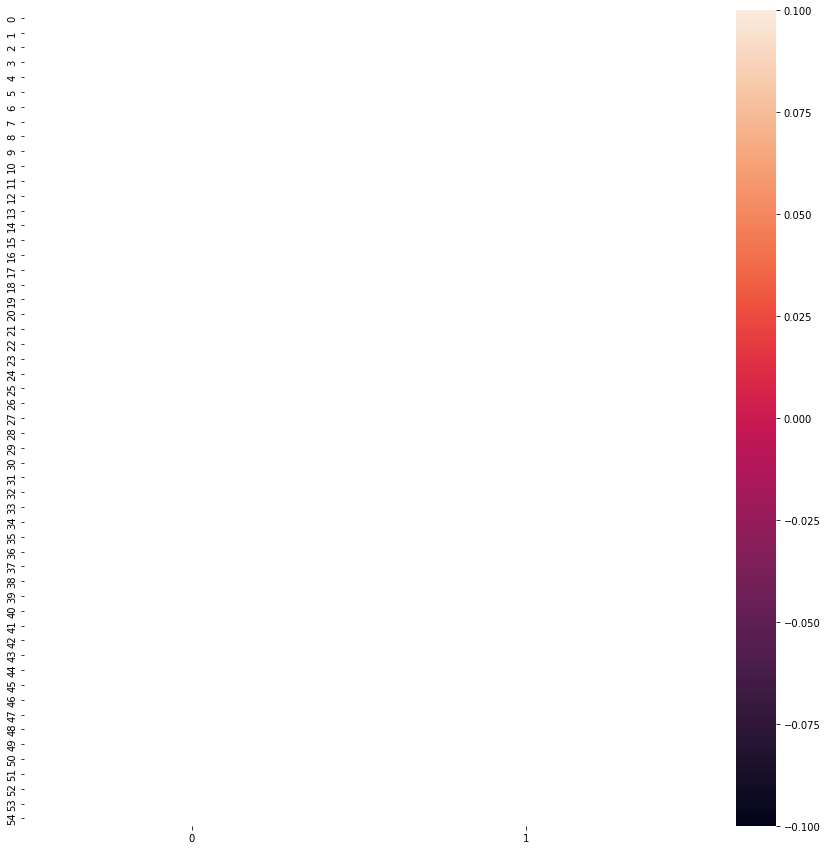

In [178]:
from itertools import product
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn

def correlation_matrix(X_, group):
    corrected_alpha = 0.05 / (len(X_.columns)*len(group_cols))

    corr = np.zeros((len(X_.columns), len(group_cols)))
    p = np.zeros((len(X_.columns), len(group_cols)))

    for (idx1, col1), (idx2, col2) in product(enumerate(X_.T.values), enumerate(group.T.values)):
        correlation, p_val = pearsonr(col1, col2)
        corr[idx1, idx2] = correlation
        p[idx1, idx2] = p_val

    plt.figure(figsize=(15,15))
    seaborn.heatmap(corr, mask=p > corrected_alpha)
    plt.show()

correlation_matrix(X_pca, group_train)

#### Project your test data with Standard PCA, and then project it back into the original space.
• Calculate the reconstruction error for each sample.
• Look at the reconstruction error per each protected group. What do you see?


In [192]:
def pca_reconstruction_mse(data, scaler):
    cols = [c for c in data.columns if c not in fuck_these + group_cols]
    data = scaler.transform(data[cols]) # remove group columns
    data_reconstructed = pca.inverse_transform(pca.transform(data))
    #mse = ((data - data_reconstructed)**2).values.mean()
    mse = mean_squared_error(data, data_reconstructed)
    return mse

groups = full_test.groupby(group_cols)
mse = lambda x: pca_reconstruction_mse(x, scaler=scaler)
display(f'{mse(X_test) = }', groups.apply(mse).rename('reconstruction_MSE'))

'mse(X_test) = 5.766885858344436e-07'

SEX  RAC1P
1    1        1.113298e-06
     2        2.991120e-30
2    1        2.323629e-30
     2        1.513403e-30
Name: reconstruction_MSE, dtype: float64

#### 3. Implement Fair PCA (refer to Lecture 7 Exercises).
• Do not forget to normalise data before applying Fair PCA.
• Use Ncomponents = Nfeatures − Nprotected groups, you have 4 protected groups).
• Look at the correlations between the new dimensions and original protected features. How
does results compare to the Standard PCA?


c:\Users\Christoffer\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\Users\Christoffer\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\Christoffer\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


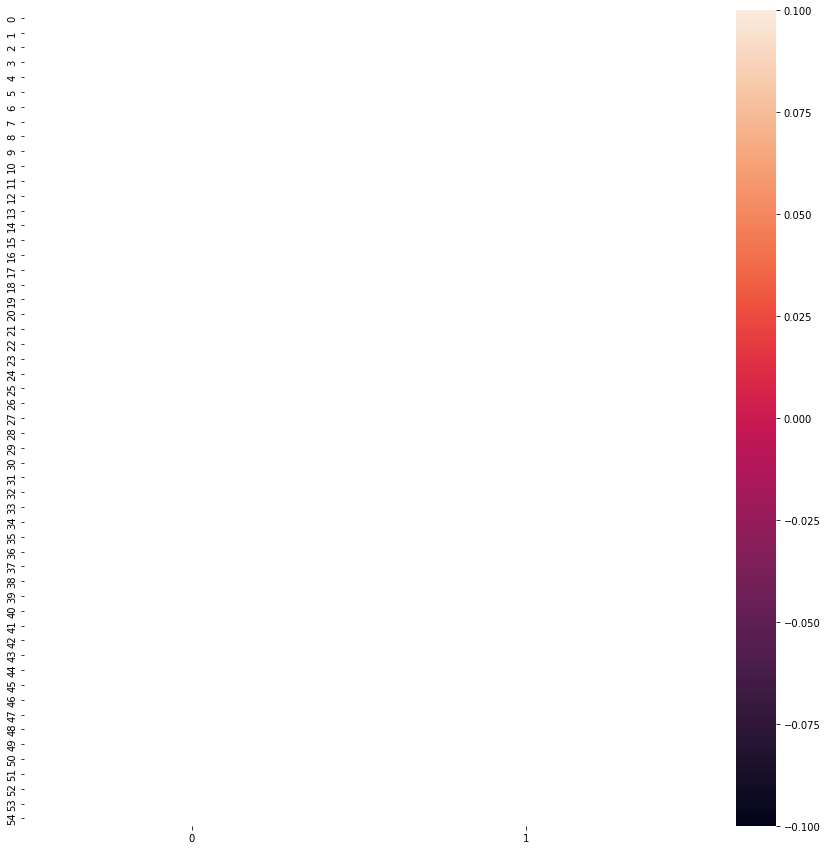

In [180]:
from scipy.linalg import null_space, eig, inv

# remember; X = scaler.fit_transform(X_train[feature_cols])
Z = group_train
R = null_space(Z.T @ X)
Λ = R.T@X.T@X@R
eigenvals, L = eig(Λ)
U = R@L[:, :n_components]
X_fair = X@U

correlation_matrix(X_fair, group_train)

#### 4. Project your test data with Fair PCA, and then project it back into the original space.
• Calculate the reconstruction error for each sample.
• Look at the reconstruction error per each protected group. What do you see? Are there any
differences compared to the Standard PCA?

In [181]:
def fair_pca_reconstruction_mse(data):
    data = scaler.transform(data[feature_cols]) # scale and remove protected columns
    data_reconstructed = data @ U @ U.T
    # mse = ((data.values - data_reconstructed)**2).values.mean()
    mse = mean_squared_error(data, data_reconstructed)
    return mse

groups = pd.concat([X_test, group_test], axis=1).groupby(group_cols)

display(f'{fair_pca_reconstruction_mse(X_test) = }', groups.apply(lambda x: fair_pca_reconstruction_mse(x)).rename('Reconstruction RMSE'))

'fair_pca_reconstruction_mse(X_test) = 0.05778994027043439'

SEX  RAC1P
1    1        0.060186
     2        0.097231
2    1        0.053579
     2        0.040022
Name: Reconstruction RMSE, dtype: float64

#### Task 2.5: Logistic Regression and Fair PCA
1. Fit a Logistic Regression (your implementation) to the debiased data (via Fair PCA).
• Do not use L2-penalisation
• Do not forget to add the column of ones for the intercept, β0.
2. Evaluate the overall performance of the final model on the Test Set (report uncertainty).
3. Look at the fairness metric associated with each SEX and RAC1P groups. Are there any discrepancies?


In [203]:
def project_full_df(df, U):
    feature_df = df[feature_cols] @ U
    X = pd.concat([feature_df, df[group_cols]], axis=1)
    X.columns = X.columns.astype(str)
    return X

In [225]:
f = project_full_df
no_l2_clf = LogReg(gamma=0, lambda_=1e4)
no_l2_clf.fit(f(full_train, U), y_train)
y_pred = no_l2_clf.predict(f(full_test, U))
(y_pred == y_test.squeeze()).mean()

0.832

In [227]:
groups = group_test.assign(y_pred=y_pred, y_true=y_test).groupby(group_cols)
groups.apply(lambda x: np.mean(x.y_pred == x.y_true)).rename('Statistical parity')

SEX  RAC1P
1    1        0.861004
     2        0.928571
2    1        0.781991
     2        0.937500
Name: Statistical parity, dtype: float64